# Homework 4: More Principal Component Analysis
***
This homework focuses on familiarizing you with low-rank approximations and multi-dimensional scaling. In addition, you will work with the CIFAR-10 dataset, a popular benchmark dataset for most classification algorithms.

# Load data

In [5]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import euclidean_distances
from scipy import linalg
from sklearn import manifold
from matplotlib import pyplot as plt
from tqdm import tqdm
%matplotlib inline

In [6]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [7]:
data_batch1 = unpickle('data/data_batch_1')
data_batch2 = unpickle('data/data_batch_2')
data_batch3 = unpickle('data/data_batch_3')
data_batch4 = unpickle('data/data_batch_4')
data_batch5 = unpickle('data/data_batch_5')

test_batch = unpickle('data/test_batch')

In [8]:
combined_data = np.concatenate((data_batch1[b'data'], data_batch2[b'data'], data_batch3[b'data'], data_batch4[b'data'], data_batch5[b'data'], test_batch[b'data']))
combined_labels = np.concatenate((data_batch1[b'labels'], data_batch2[b'labels'], data_batch3[b'labels'], data_batch4[b'labels'], data_batch5[b'labels'], test_batch[b'labels']))
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Part A

In [9]:
def getPCA(data, n_components):
    pca = PCA(n_components)
    pca.fit(data)
    return pca

In [10]:
def aggregateByCategory(data, labels): 
    imageByCategory = {}
    for index in range(len(data)):
        label = labels[index]
        if(label not in imageByCategory):
            imageByCategory[label] = []
        imageByCategory[label].append(data[index])
    return imageByCategory

In [11]:
def getPCAForImages(images):
    categoryPCA = {}
    for category in imagesByCategory:
        images = np.array(imagesByCategory[category])
        categoryPCA[category] = getPCA(images, 20)
    return categoryPCA

In [12]:
def showImage(pixels, label):
    pixels = np.reshape(pixels,(3,1024))
    pixels = np.transpose(pixels)
    pixels = np.reshape(pixels,(32,32,3))
    pixels.astype('uint8')
    plt.title(label)
    plt.imshow(pixels)
    plt.show()

In [177]:
mean_images = np.zeros((10, 3072))

for i in range(0, 60000):
    mean_images[combined_labels[i]] = mean_images[combined_labels[i]] + combined_data[i]

mean_images = mean_images / 6000
mean_images = mean_images.astype('uint8')  

## Show mean images by class

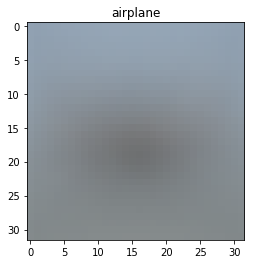

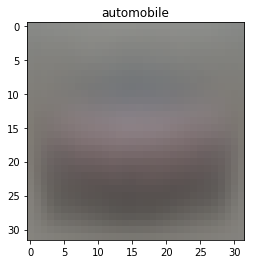

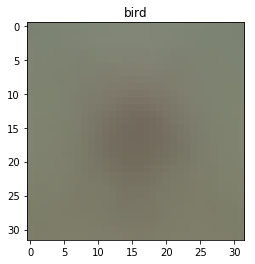

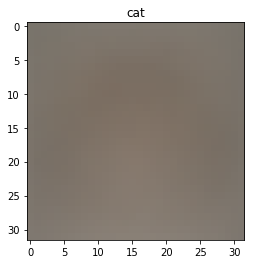

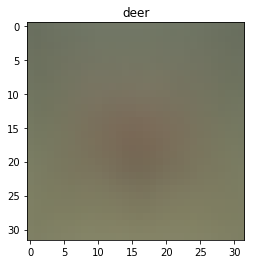

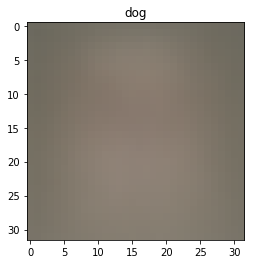

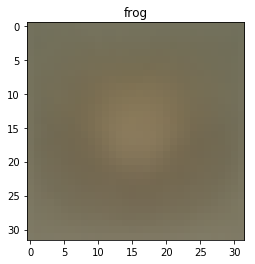

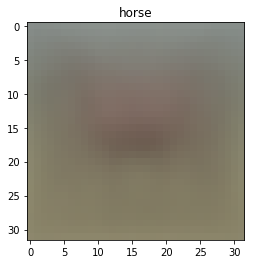

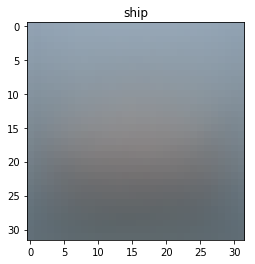

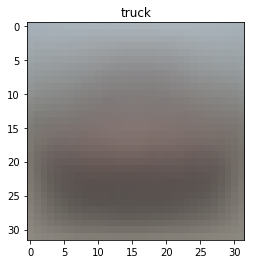

In [14]:
for i in range(0, 10):
    showImage(mean_images[i], label_names[i])

## PCA first 20 principal components

In [15]:
imagesByCategory = aggregateByCategory(combined_data, combined_labels)

In [16]:
pcaByImageCategory = getPCAForImages(imagesByCategory)

## Compute a low-dimensional reconstruction of each image in the class

In [17]:
imagesByCategoryReconstructed = np.zeros(184320000).reshape(10, 6000, 3072)

In [18]:
for cat in imagesByCategory:
        imagesByCategoryReconstructed[cat] = pcaByImageCategory[cat].inverse_transform(pcaByImageCategory[cat].transform(imagesByCategory[cat]))

## For each image, compute the squared difference between the original and reconstructed version, and sum this over all pixels over all channels.

In [19]:
sq_diff = np.zeros(10)

for i in range(0, 10):
    sq_diff[i] = (np.linalg.norm(imagesByCategory[i]-imagesByCategoryReconstructed[i])**2)/6000
    print ("Average of sums of squared difference for class", i, ":", sq_diff[i])

Average of sums of squared difference for class 0 : 2620521.4365466605
Average of sums of squared difference for class 1 : 3950755.973577468
Average of sums of squared difference for class 2 : 2447702.2990006576
Average of sums of squared difference for class 3 : 3116483.98621016
Average of sums of squared difference for class 4 : 2180393.867995958
Average of sums of squared difference for class 5 : 3231131.7270500716
Average of sums of squared difference for class 6 : 2630247.4604280633
Average of sums of squared difference for class 7 : 3441114.6570812627
Average of sums of squared difference for class 8 : 2440640.8759648083
Average of sums of squared difference for class 9 : 4021099.3777399305


## Bar graph showing the squared difference for each class

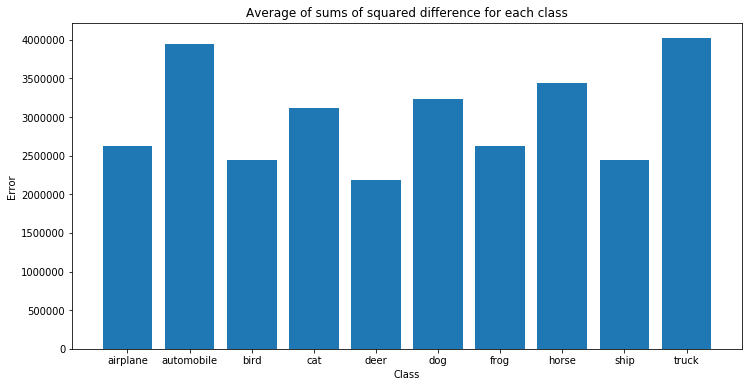

In [20]:
from matplotlib.pyplot import figure
figure(figsize=(12, 6))

y_pos = np.arange(len(label_names))
plt.bar(y_pos, sq_diff, align='center')
plt.xticks(y_pos, label_names)
plt.ylabel('Error')
plt.xlabel('Class')
plt.title('Average of sums of squared difference for each class')
plt.show()

# Part B

In [21]:
def calculateDistance(mean_images):
    length = len(mean_images)
    distance = np.zeros((10,10))
    for i in range(length):
        for j in range(length):
            a = mean_images[i].reshape(1,-1)
            b = mean_images[j].reshape(1,-1)
            distance[i,j] = euclidean_distances(a, b)
    return np.square(distance)

In [130]:
def calculateMDS(distance_matrix):
    length = len(mean_images)
    A = np.identity(10) - np.ones([10, 10]) * 0.1
    W = -(0.5 * np.dot(np.dot(A, distance_matrix), A.T))
    eigenvalue, eigenvector = linalg.eig(W)
    idx = eigenvalue.argsort()[::-1]
    eigenvalue = eigenvalue[idx]
    eigenvector = eigenvector[:,idx]
    t = np.zeros([2,2])
    t[0][0] = np.sqrt(eigenvalue[0])
    t[1][1] = np.sqrt(eigenvalue[1])
    Y = np.dot(eigenvector[:, :2], t)
    return Y

In [174]:
distance_matrix = calculateDistance(mean_images)
np.savetxt("partb_distances.csv", distance_matrix, delimiter=",", fmt='%f')

In [175]:
mds = calculateMDS(distance_matrix)

/Users/edgarpino/miniconda2/lib/python3.7/site-packages/ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.
/Users/edgarpino/miniconda2/lib/python3.7/site-packages/ipykernel_launcher.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  # This is added back by InteractiveShellApp.init_path()


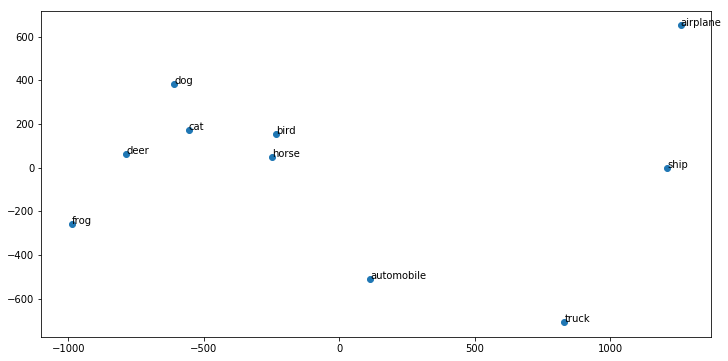

In [176]:
figure(figsize=(12, 6))

for i, txt in enumerate(label_names):
    plt.annotate(txt, (np.real(mds[i, 0]), np.real(mds[i, 1])))
    
plt.scatter(np.real(mds[:,0]), np.real(mds[:,1]))
plt.show()

# Part C
- https://piazza.com/class/jqo7mhnnyiy698?cid=595
- https://piazza.com/class/jqo7mhnnyiy698?cid=579
- https://piazza.com/class/jqo7mhnnyiy698?cid=522

In [178]:
def calculateDistanceC(mean_images, pcaByImageCategory, imagesByCategory):
    length = len(mean_images)
    distances = np.zeros((10,10))
    for a in tqdm(range(length)):
        meanA = mean_images[a]
        for b in range(length):
            # A
            pca = PCA(n_components=20)
            pca.fit(imagesByCategory[b])
            pca.mean_ = meanA
            A_trans = pca.fit_transform(imagesByCategory[a])
            A_recon = pca.inverse_transform(A_trans)
            distanceAB = (np.linalg.norm(np.array(imagesByCategory[a]) - A_recon)**2) / 6000
            
            # B
            pcaB = PCA(n_components=20)
            pcaB.fit(imagesByCategory[a])
            pcaB.mean_ = mean_images[b]
            B_trans = pcaB.fit_transform(imagesByCategory[b])
            B_recon = pcaB.inverse_transform(B_trans)
            distanceBA = (np.linalg.norm(np.array(imagesByCategory[b]) - B_recon)**2) / 6000
            
            AB = (distanceAB + distanceBA)/2
            distances[a,b] = AB
    return distances

In [179]:
partc_distances = calculateDistanceC(mean_images, pcaByImageCategory, imagesByCategory)


100%|██████████| 10/10 [05:26<00:00, 31.28s/it]

In [183]:
np.savetxt("partc_distances.csv", partc_distances, delimiter=",", fmt='%f')

In [184]:
mdsC = calculateMDS(partc_distances)

/Users/edgarpino/miniconda2/lib/python3.7/site-packages/ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.
/Users/edgarpino/miniconda2/lib/python3.7/site-packages/ipykernel_launcher.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  # This is added back by InteractiveShellApp.init_path()


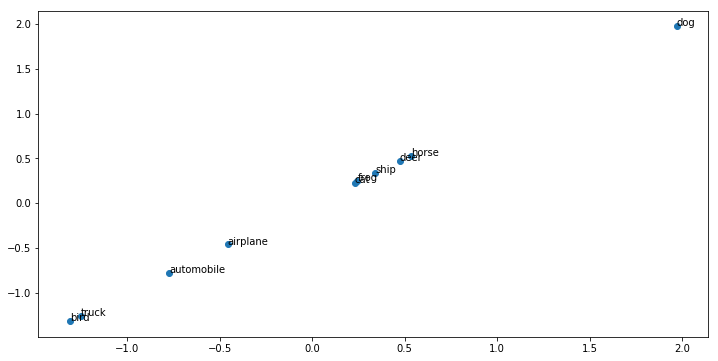

In [185]:
figure(figsize=(12, 6))

for i, txt in enumerate(label_names):
    plt.annotate(txt, (np.real(mdsC[i, 0]), np.real(mdsC[i, 1])))
    
plt.scatter(np.real(mdsC[:,0]), np.real(mdsC[:,1]))
plt.show()